In [48]:
import numpy as np
import pandas as pd
import ta
import scipy.stats
from datetime import datetime
import math
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler, MinMaxScaler, normalize
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import yfinance as yf

In [49]:
# ?GaussianNB

In [50]:
def preprocessing_yf(symbol):
    global df
 #Import data
    df = yf.download(symbol).dropna()

 #Rename
    df.columns = ["Open", "High", "Low", "Close", "Adj Close", "Volume"]
    df.index.name = "Date"

    #Remove adj close
    # del df["adj close"]

    return df

In [51]:
df = preprocessing_yf("AAPL")
df = df.rename_axis('Date').reset_index()
# df['Date'] = df['Date'].strftime('%Y-%m-%d')

df.tail()

[*********************100%%**********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
10929,2024-04-22,165.520004,167.259995,164.770004,165.839996,165.839996,48116400
10930,2024-04-23,165.350006,167.050003,164.919998,166.899994,166.899994,49537800
10931,2024-04-24,166.539993,169.300003,166.210007,169.020004,169.020004,48251800
10932,2024-04-25,169.529999,170.610001,168.149994,169.889999,169.889999,50558300
10933,2024-04-26,169.880005,171.339996,169.179993,169.300003,169.300003,44525100


In [52]:
#df = preprocessing_yf("MMM")


In [53]:
# df = pd.read_csv("./data/SNP.csv")
# df.tail()

In [54]:
df = ta.add_all_ta_features(
    df, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

# Slow : 60+
# Fast : 15
# df['date'] = df['Date'].apply(lambda x: datetime.strptime(str(x),"%Y-%m-%d"))

df.columns[25:]

Index(['volatility_kch', 'volatility_kcl', 'volatility_kcw', 'volatility_kcp',
       'volatility_kchi', 'volatility_kcli', 'volatility_dcl',
       'volatility_dch', 'volatility_dcm', 'volatility_dcw', 'volatility_dcp',
       'volatility_atr', 'volatility_ui', 'trend_macd', 'trend_macd_signal',
       'trend_macd_diff', 'trend_sma_fast', 'trend_sma_slow', 'trend_ema_fast',
       'trend_ema_slow', 'trend_vortex_ind_pos', 'trend_vortex_ind_neg',
       'trend_vortex_ind_diff', 'trend_trix', 'trend_mass_index', 'trend_dpo',
       'trend_kst', 'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_ichimoku_b',
       'trend_stc', 'trend_adx', 'trend_adx_pos', 'trend_adx_neg', 'trend_cci',
       'trend_visual_ichimoku_a', 'trend_visual_ichimoku_b', 'trend_aroon_up',
       'trend_aroon_down', 'trend_aroon_ind', 'trend_psar_up',
       'trend_psar_down', 'trend_psar_up_indicator',
       'trend_psar_down_indicator', 'momentum_r

In [55]:
from pyti import catch_errors
import warnings
def chande_momentum_oscillator(close_data, period):
    """
    Chande Momentum Oscillator.

    Formula:
    cmo = 100 * ((sum_up - sum_down) / (sum_up + sum_down))
    """
    catch_errors.check_for_period_error(close_data, period)

    close_data = np.array(close_data)

    moving_period_diffs = [[(close_data[idx+1-period:idx+1][i] -
                 close_data[idx+1-period:idx+1][i-1]) for i in range(1, len(close_data[idx+1-period:idx+1]))] for idx in range(0, len(close_data))]

    sum_up = []
    sum_down = []
    for period_diffs in moving_period_diffs:
        ups = [val if val > 0 else 0 for val in period_diffs]
        sum_up.append(sum(ups))
        downs = [abs(val) if val < 0 else 0 for val in period_diffs]
        sum_down.append(sum(downs))

    sum_up = np.array(sum_up)
    sum_down = np.array(sum_down)
    # numpy is able to handle dividing by zero and makes those calculations
    # nans which is what we want, so we safely suppress the RuntimeWarning
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        cmo = 100 * ((sum_up - sum_down) / (sum_up + sum_down))
    return cmo

# print(df['CMO'])
# plt.plot(df['Date'],df['CMO'])
# plt.plot(df['Date'],df['Close'])
# plt.show()
# fig, ax1 = plt.subplots(figsize=(8, 8))
# ax2 = ax1.twinx()

# ax1.plot(df['Date'],df['CMO'])
# ax2.plot(df['Date'],df['Close']);

In [56]:
# Feature Vector Calculations.
df['priceChange'] = df['Close']-df['Open']
df['priceChange_p'] = (df['Close']-df['Open'])/df['Open']
df['classPriceChange'] = 1*(df['priceChange']>0.01)
df['dateInt'] = df['Date'].apply(lambda x: (x - datetime(1970,1,1)).days)
df['close_r20'] = df.Close.rolling(20).mean()
df['close_r200'] = df.Close.rolling(200).mean()
df['APO_momentum'] = df['close_r20']-df['close_r200']
df['BOP'] = ((df['Close']-df['Open'])/(df['High']-df['Low'])).rolling(14).mean()
df['CMO'] = chande_momentum_oscillator(df['Close'],period=20)
df['Momentum_10'] = df["Close"]-df["Close"].shift(10)

# Fast SMA is 12 days
# Slow EMA is 26 days

df['medPrice'] = ((df['High']+df['Low'])/2)
df['typPrice'] = ((df['High']+df['Low']+df['Close'])/3)
df['wtyPrice'] = ((df['High']+df['Low']+2*df['Close'])/3)

C:\Users\mlilje01\AppData\Local\Temp\ipykernel_26544\3964959916.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['typPrice'] = ((df['High']+df['Low']+df['Close'])/3)
C:\Users\mlilje01\AppData\Local\Temp\ipykernel_26544\3964959916.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['wtyPrice'] = ((df['High']+df['Low']+2*df['Close'])/3)


In [57]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,...,dateInt,close_r20,close_r200,APO_momentum,BOP,CMO,Momentum_10,medPrice,typPrice,wtyPrice
10929,2024-04-22,165.520004,167.259995,164.770004,165.839996,165.839996,48116400,4.614827e+10,222903571800,-0.156582,...,19835,169.885500,182.06985,-12.184351,-0.122363,-13.536916,-2.610001,166.014999,165.956665,221.236664
10930,2024-04-23,165.350006,167.050003,164.919998,166.899994,166.899994,49537800,4.619083e+10,222953109600,-0.126132,...,19836,169.687999,181.95095,-12.262951,-0.099637,-7.609029,-2.770004,165.985001,166.289998,221.923330
10931,2024-04-24,166.539993,169.300003,166.210007,169.020004,169.020004,48251800,4.623034e+10,223001361400,-0.049406,...,19837,169.653499,181.85300,-12.199501,-0.008438,-12.101534,1.240005,167.755005,168.176671,224.516673
10932,2024-04-25,169.529999,170.610001,168.149994,169.889999,169.889999,50558300,4.625130e+10,223051919700,-0.075696,...,19838,169.482499,181.76205,-12.279551,0.002511,-4.610023,-5.149994,169.379997,169.549998,226.179998
10933,2024-04-26,169.880005,171.339996,169.179993,169.300003,169.300003,44525100,4.621172e+10,223007394600,-0.120309,...,19839,169.373499,181.65970,-12.286201,0.026486,-2.170669,-7.250000,170.259995,169.939997,226.373332


In [58]:
np.mean(df['classPriceChange'])

0.2738247667825133

In [59]:
list(df.columns)

['Date',
 'Open',
 'High',
 'Low',
 'Close',
 'Adj Close',
 'Volume',
 'volume_adi',
 'volume_obv',
 'volume_cmf',
 'volume_fi',
 'volume_em',
 'volume_sma_em',
 'volume_vpt',
 'volume_vwap',
 'volume_mfi',
 'volume_nvi',
 'volatility_bbm',
 'volatility_bbh',
 'volatility_bbl',
 'volatility_bbw',
 'volatility_bbp',
 'volatility_bbhi',
 'volatility_bbli',
 'volatility_kcc',
 'volatility_kch',
 'volatility_kcl',
 'volatility_kcw',
 'volatility_kcp',
 'volatility_kchi',
 'volatility_kcli',
 'volatility_dcl',
 'volatility_dch',
 'volatility_dcm',
 'volatility_dcw',
 'volatility_dcp',
 'volatility_atr',
 'volatility_ui',
 'trend_macd',
 'trend_macd_signal',
 'trend_macd_diff',
 'trend_sma_fast',
 'trend_sma_slow',
 'trend_ema_fast',
 'trend_ema_slow',
 'trend_vortex_ind_pos',
 'trend_vortex_ind_neg',
 'trend_vortex_ind_diff',
 'trend_trix',
 'trend_mass_index',
 'trend_dpo',
 'trend_kst',
 'trend_kst_sig',
 'trend_kst_diff',
 'trend_ichimoku_conv',
 'trend_ichimoku_base',
 'trend_ichimoku_a

In [60]:
df.columns[-9:]

Index(['close_r20', 'close_r200', 'APO_momentum', 'BOP', 'CMO', 'Momentum_10',
       'medPrice', 'typPrice', 'wtyPrice'],
      dtype='object')

In [61]:
df2 = pd.concat(
    [
        df[['classPriceChange','priceChange','Date','dateInt']],
        df[list(df.columns[7:93])].shift(1),
        #df[['priceChange_p']].shift(1),
        df[list(df.columns[-9:])].shift(1),
    ],
    axis=1).dropna()
df2 = df2[1:].reset_index(drop=True)
df2.head()
print(df2.iloc[:,1:5])
# print(df2[1:5])
# df3 = df2.iloc[:, ::-1]
# print(df3)

       priceChange       Date  dateInt    volume_adi
0         0.000000 1981-09-30     4290 -6.963824e+09
1         0.000000 1981-10-01     4291 -7.013821e+09
2         0.000000 1981-10-02     4292 -7.074950e+09
3         0.000000 1981-10-05     4295 -7.119997e+09
4        -0.000558 1981-10-06     4296 -7.163094e+09
...            ...        ...      ...           ...
10536     0.319992 2024-04-22    19835  4.615503e+10
10537     1.549988 2024-04-23    19836  4.614827e+10
10538     2.480011 2024-04-24    19837  4.619083e+10
10539     0.360001 2024-04-25    19838  4.623034e+10
10540    -0.580002 2024-04-26    19839  4.625130e+10

[10541 rows x 4 columns]


In [62]:
df2.columns

Index(['classPriceChange', 'priceChange', 'Date', 'dateInt', 'volume_adi',
       'volume_obv', 'volume_cmf', 'volume_fi', 'volume_em', 'volume_sma_em',
       'volume_vpt', 'volume_vwap', 'volume_mfi', 'volume_nvi',
       'volatility_bbm', 'volatility_bbh', 'volatility_bbl', 'volatility_bbw',
       'volatility_bbp', 'volatility_bbhi', 'volatility_bbli',
       'volatility_kcc', 'volatility_kch', 'volatility_kcl', 'volatility_kcw',
       'volatility_kcp', 'volatility_kchi', 'volatility_kcli',
       'volatility_dcl', 'volatility_dch', 'volatility_dcm', 'volatility_dcw',
       'volatility_dcp', 'volatility_atr', 'volatility_ui', 'trend_macd',
       'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       '

In [63]:
from sklearn.model_selection import train_test_split
all_x = df2[df2.columns[3:]].values
all_y = df2['classPriceChange'].values
#df_input.head()

print(all_x.shape)

custom_mask = np.array(list(map(lambda x: x<np.datetime64('2020-01-01'),df2['Date'].values)))
train_x = all_x[custom_mask]
train_y = all_y[custom_mask]
test_x = all_x[~custom_mask]
test_y = all_y[~custom_mask]
train_x, test_x, train_y, test_y = train_test_split(
    all_x, all_y, test_size=0.30, random_state=42)

(10541, 96)


In [64]:
df2.columns[3:]

Index(['dateInt', 'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi',
       'volume_em', 'volume_sma_em', 'volume_vpt', 'volume_vwap', 'volume_mfi',
       'volume_nvi', 'volatility_bbm', 'volatility_bbh', 'volatility_bbl',
       'volatility_bbw', 'volatility_bbp', 'volatility_bbhi',
       'volatility_bbli', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
       'volatility_kcw', 'volatility_kcp', 'volatility_kchi',
       'volatility_kcli', 'volatility_dcl', 'volatility_dch', 'volatility_dcm',
       'volatility_dcw', 'volatility_dcp', 'volatility_atr', 'volatility_ui',
       'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_sma_fast',
       'trend_sma_slow', 'trend_ema_fast', 'trend_ema_slow',
       'trend_vortex_ind_pos', 'trend_vortex_ind_neg', 'trend_vortex_ind_diff',
       'trend_trix', 'trend_mass_index', 'trend_dpo', 'trend_kst',
       'trend_kst_sig', 'trend_kst_diff', 'trend_ichimoku_conv',
       'trend_ichimoku_base', 'trend_ichimoku_a', 'trend_i

In [65]:
train_x.shape

(7378, 96)

In [66]:
myPipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lda',LinearDiscriminantAnalysis()),
    ('gnb', GaussianNB())])

parameter_grid = {
    #'pca__n_components':[1,3,5,7,9,11],
    'gnb__var_smoothing':np.logspace(-8,2,11)
}

clf = GridSearchCV(myPipeline,
                   parameter_grid,
                   cv=5,
                   return_train_score=True)
clf.fit(train_x,train_y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('lda', LinearDiscriminantAnalysis()),
                                       ('gnb', GaussianNB())]),
             param_grid={'gnb__var_smoothing': array([1.e-08, 1.e-07, 1.e-06, 1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01,
       1.e+00, 1.e+01, 1.e+02])},
             return_train_score=True)

Best Parameter Selected:	: {'gnb__var_smoothing': 0.1}
Optimal Train Threshold:	 0.53
Holdout Confusion Matrix
[[1993  290]
 [ 604  276]]
Holdout Model Accuracy:	 0.7173569396142903


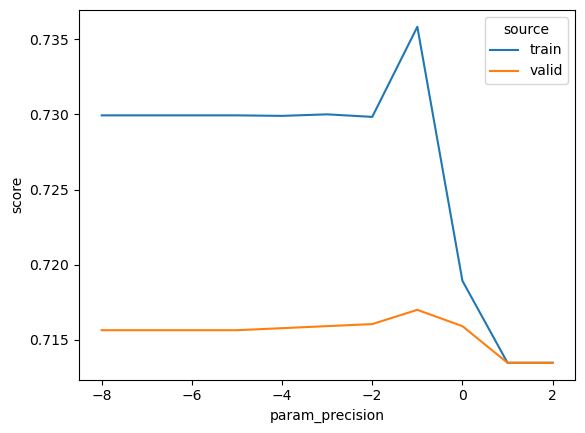

In [67]:
param_precision = [np.log10(x) for x in clf.cv_results_['param_gnb__var_smoothing'].data]

df_cvtrain = pd.DataFrame(
    {'source':'train',
     'param_precision':param_precision,
     'score':clf.cv_results_['mean_train_score']})

df_cvvalid = pd.DataFrame(
    {'source':'valid',
     'param_precision':param_precision,
     'score':clf.cv_results_['mean_test_score']})

df_cv = pd.concat([df_cvtrain,df_cvvalid])

sns.lineplot(data=df_cv, x="param_precision",y='score',hue="source")

print("Best Parameter Selected:\t:",clf.best_params_)

# Get optimal Threshold
thresholds = np.arange(.01,.99,.01)
train_yhatprob = clf.best_estimator_.predict_proba(train_x)[:, 1]
thresh_scores = list(map(
    lambda x: accuracy_score(train_y,train_yhatprob>x),thresholds))
best_score = thresh_scores[np.argmax(thresh_scores)]
threshold = thresholds[thresh_scores == best_score][0]
print("Optimal Train Threshold:\t",threshold)

#threshold =.5

test_yhat = (clf.best_estimator_.predict_proba(test_x)[:, 1] > threshold).astype('float')

print("Holdout Confusion Matrix")
print(confusion_matrix(test_y,test_yhat))

print("Holdout Model Accuracy:\t",accuracy_score(test_y,test_yhat))

(array([915., 534., 138.,  80., 135., 143., 363., 559., 256.,  40.]),
 array([0.01315811, 0.08212366, 0.15108922, 0.22005477, 0.28902033,
        0.35798588, 0.42695143, 0.49591699, 0.56488254, 0.63384809,
        0.70281365]),
 <BarContainer object of 10 artists>)

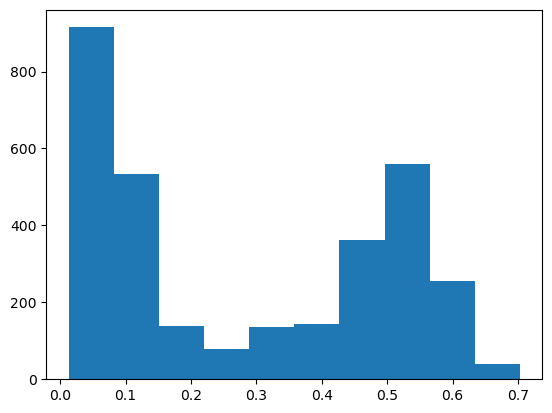

In [68]:
plt.hist(clf.best_estimator_.predict_proba(test_x)[:, 1])

In [69]:
# # pd.set_option("max_columns", None) # show all cols
# pd.options.display.max_colwidth = 100
# pd.set_option('max_colwidth', None) # show full width of showing cols
# pd.set_option("expand_frame_repr", False) # print cols side by side as it's supposed to be
# pd.options.display.max_seq_items = 200000
# pd.options.display.max_rows = 400000
# print(str(test_yhat))
# print(clf.best_estimator_.predict_proba(test_x))
# print((sum(clf.best_estimator_.predict_proba(test_x)[:, 1] > 0.6).astype('float')))
# # print(clf.best_estimator_.predict(test_x)[20:30])

In [70]:
# print(test_yhat)
# print(df2.columns)
dummy = df['Close'].loc[df['Date']>=datetime(2020,1,1)]
print(df['Date'].loc[df['Date']>=datetime(2020,1,1)])
print(dummy)
print(dummy.iloc[1])
#print(pct.iloc[1])

9847    2020-01-02
9848    2020-01-03
9849    2020-01-06
9850    2020-01-07
9851    2020-01-08
           ...    
10929   2024-04-22
10930   2024-04-23
10931   2024-04-24
10932   2024-04-25
10933   2024-04-26
Name: Date, Length: 1087, dtype: datetime64[ns]
9847      75.087502
9848      74.357498
9849      74.949997
9850      74.597504
9851      75.797501
            ...    
10929    165.839996
10930    166.899994
10931    169.020004
10932    169.889999
10933    169.300003
Name: Close, Length: 1087, dtype: float64
74.35749816894531


In [71]:

backtest_mask = (df2['Date'] >= datetime(2020,1,1))  #DATES TO USE BACKTEST TO DETERMINE PROFITABILITY
backtest_x = all_x[backtest_mask]
backtest_y = (clf.best_estimator_.predict_proba(backtest_x)[:, 1] > threshold).astype('float')
position = backtest_y*1
# print(position.shape)
position[position==0]=-1
# print(position)
index_values = df['Date'].loc[df['Date']>=datetime(2020,1,3)]
# print(index_values.shape)
dfpos=pd.DataFrame(position[1:],index=index_values)
print(dfpos.shape)
# print(df2['Date'].loc[backtest_mask])

# print(backtest_x.shape)
pct = df['Close'].loc[df['Date']>=datetime(2020,1,1)].pct_change(1).dropna() ##takes the percentage change of the close between each row, between every day since the input is 1, if input was 2, it would be the percent change of the stock over every 2 days
dfpct = pd.DataFrame(pct.values, index=index_values)
returnoninvestment = dfpct* dfpos.shift(1)  #calculate the return of our strategy (shift(1) tells program to use the previous position in the calculation because that tells us how much percent change that position has gained or lost from then to the present)
dfreturn = pd.DataFrame(returnoninvestment, index=index_values).dropna()
# print(dfreturn)
# dfreturn = dfreturn.rename(columns={'0':'return'})
dfreturn.name='return'
print(dfreturn)

(1086, 1)
                   0
Date                
2020-01-06 -0.007968
2020-01-07  0.004703
2020-01-08 -0.016086
2020-01-09  0.021241
2020-01-10 -0.002261
...              ...
2024-04-22  0.005091
2024-04-23  0.006392
2024-04-24  0.012702
2024-04-25  0.005147
2024-04-26 -0.003473

[1085 rows x 1 columns]


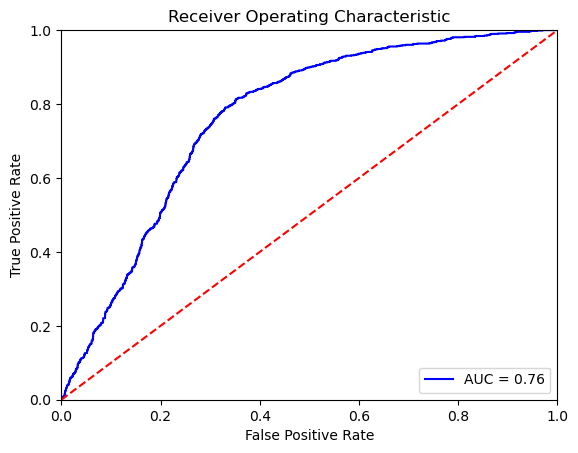

In [72]:
from sklearn import metrics

probs = clf.predict_proba(test_x)
prob_prd = probs[:,1]

fpr, tpr, threshold = metrics.roc_curve(test_y, prob_prd)
roc_auc = metrics.auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [73]:
all_x.shape

(10541, 96)

In [74]:
from sklearn.preprocessing import PolynomialFeatures

In [75]:
X = np.arange(6).reshape(3, 2)

In [76]:
def drawdown_function(series):
    cum = series.dropna().cumsum() + 1
    running_max = np.maximum.accumulate(cum)   #this function accumulates the max of the cumulative sum, for example (1,3,5,3,1) becomes (1,3,5,5,5) this will continue with 5 until a higher value comes along

    drawdown = cum/running_max -1
    return drawdown

[*********************100%%**********************]  1 of 1 completed


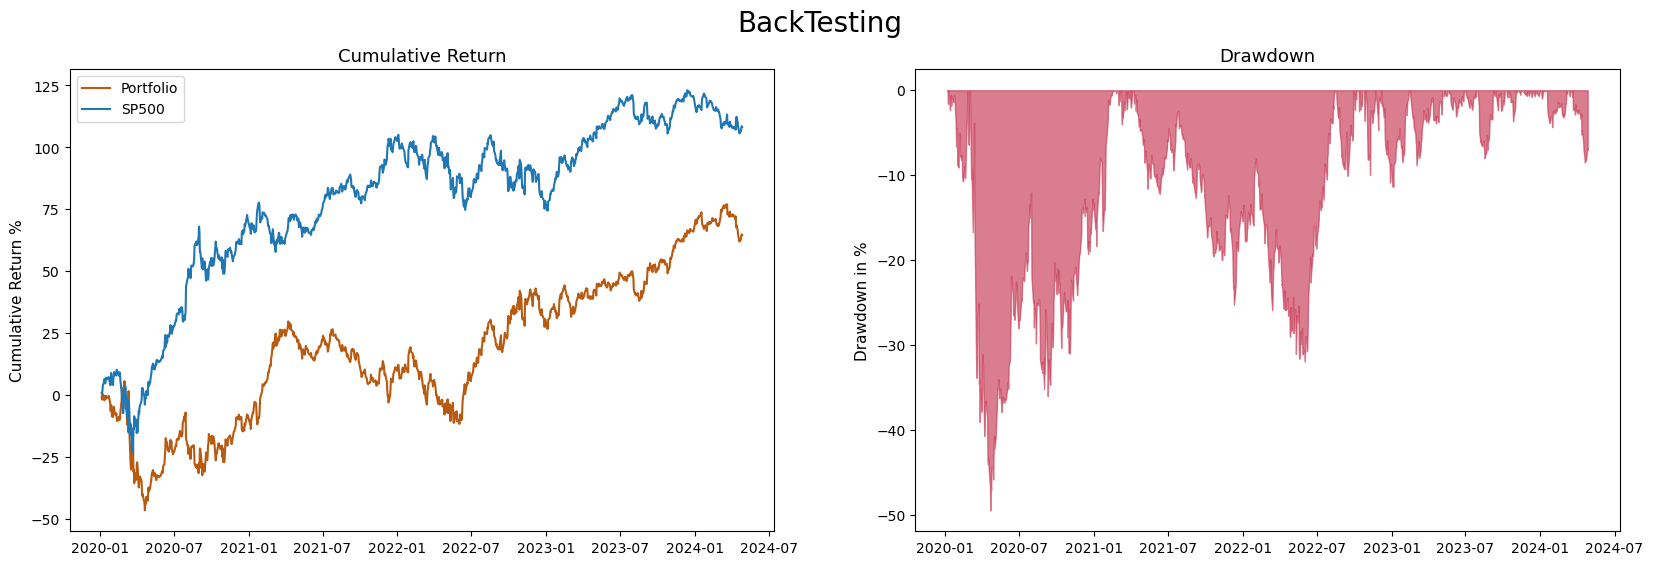

Sortino: 0.605
Beta:0.119
Alpha:13.209 %
Max Drawdown:49.43 %


In [78]:
#### Backtest Function ####
def BackTest(series, annualized_scalar=252):   #default annualized_scalar data to 252 for daily sortino and alpha. if annualized_scalar = 12, this would correspond to monthly data.
    sp500 = yf.download("AAPL")["Adj Close"].pct_change(1) # import percent change of daily close every day

    sp500.name = "SP500" #Change the name
    series.name='return'
    val = pd.concat((series, sp500), axis=1).dropna() # put together the return of our data and the return of the sp500 concatenated along columns
  
    drawdown = drawdown_function(series) *100 # compute the drawdown (the risk of strategy)

    max_drawdown= - np.min(drawdown) #compute max drawdown

    fig, (cum, dra) = plt.subplots(1,2, figsize=(20,6)) #initialize two subplots, 'cum' and 'dra'
    fig.suptitle("BackTesting", size=20)  #add subtitle


    cum.plot(series.cumsum()*100, color = "#B85A0F") # plot cumulative sum of returns for data
    cum.plot(val["SP500"].cumsum()*100)#, color = "B85A0F") #plot cumulative sum of returns for index (index meant to represent the market)
    cum.legend(["Portfolio", "SP500"])
    cum.set_title("Cumulative Return", size= 13)
    cum.set_ylabel("Cumulative Return %", size = 11)

    # print(drawdown)
    # print(drawdown.index)
    # print(drawdown.shape)
    dra.fill_between(drawdown.index, 0, drawdown, color = "#C73954", alpha=0.65) #Adds plot of the drawdown, with all the space between y=0 and y=drawdown being filled (what fill_between does) over the domain of the time the data takes place over fill_between(x, y1, y2=0)
    dra.set_title("Drawdown", size = 13)
    dra.set_ylabel("Drawdown in %", size=11)
    plt.show()
    # print(val)
    sortino = np.sqrt(annualized_scalar) * series.mean()/series.loc[series<0].std() #compute the sortino 
    beta = np.cov(val[["return", "SP500"]].values, rowvar=False)[0][1] / np.var(val["SP500"].values) #compute the beta
    alpha = (annualized_scalar) * series.mean() - (annualized_scalar)*beta*series.mean() #compute the alpha

    print(f"Sortino: {np.round(sortino,3)}")
    print(f"Beta:{np.round(beta,3)}")
    print(f"Alpha:{np.round(alpha*100,3)} %")
    print(f"Max Drawdown:{np.round(max_drawdown,3)} %")

    ######################
BackTest(dfreturn.squeeze())

In [ ]:
# 1 cent (SP500)
#   Sortino 0.357
#   Beta 0.053
#   Alpha 5.964 %
#   Max Drawdown 46.649 %
#   
#   Holdout Model Accuracy:	 0.6699741156169111

In [ ]:
# 50 cent (SP500)
#   Sortino: -0.018
#   Beta:0.0
#   Alpha:-0.348 %
#   Max Drawdown:65.016 %
#   
#   Holdout Model Accuracy:	 0.676876617773943

In [ ]:
# 1 cent (AAPL)
#   Sortino 2.11
#   Beta 0.266
#   Alpha 35.538 %
#   Max Drawdown 23.191 %
#   
#   Holdout Model Accuracy:	 0.7234716503009186



# Sortino: 0.605
# Beta:0.119
# Alpha:13.209 %
# Max Drawdown:49.43 %

In [ ]:
# 10 cent (AAPL)
#   Sortino 0.323
#   Beta -0.179
#   Alpha 9.615 %
#   Max Drawdown 88.134 %
#
#   Holdout Model Accuracy:	 0.85 (?)

In [ ]:
# 10 cent (GOOG)
# Sortino: 0.671
# Beta:0.262
# Alpha:12.611 %
# Max Drawdown:37.477 %
#   
#  Holdout Model Accuracy:	 0.6347642505277973